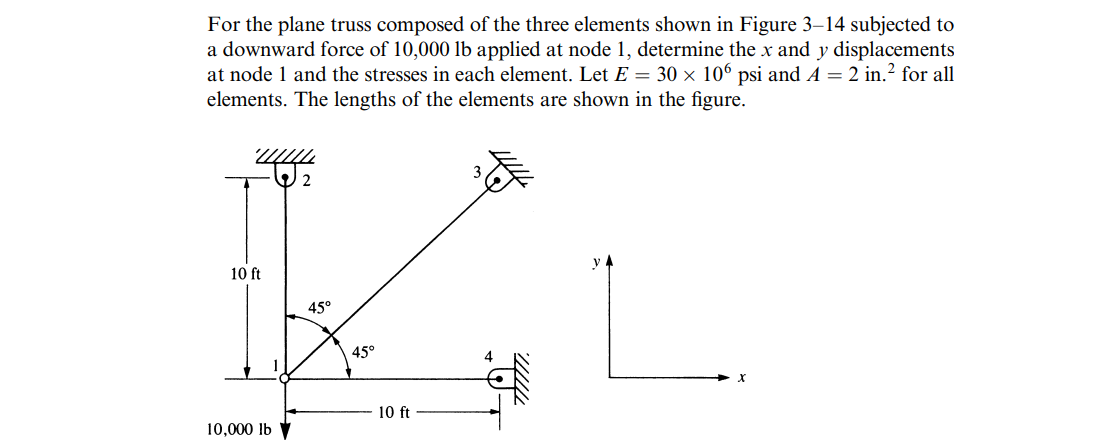image.png

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

Creating nodes

In [2]:
columns = ['coordinate_x','coordinate_y','displacement_x','displacement_y','load_x','load_y']
data = [[0,0,np.nan,np.nan,0,-10000],
        [0,120,0,0,np.nan,np.nan],
        [120,120,0,0,np.nan,np.nan],
        [120,0,0,0,np.nan,np.nan]]
nodes = pd.DataFrame(data,columns=columns)
nodes

,coordinate_x,coordinate_y,displacement_x,displacement_y,load_x,load_y
0,0,0,NaN,NaN,0.0,-10000.0
1,0,120,0.0,0.0,NaN,NaN
2,120,120,0.0,0.0,NaN,NaN
3,120,0,0.0,0.0,NaN,NaN


creating elements

In [3]:
columns = ['start','end','area','material']
data = [[0,1,2,30e6],
        [0,2,2,30e6],
        [0,3,2,30e6]]
elements = pd.DataFrame(data,columns=columns)
elements

,start,end,area,material
0,0,1,2,30000000.0
1,0,2,2,30000000.0
2,0,3,2,30000000.0


Local stiffness matrix

In [4]:
def compute(element):
    start = element['start']
    end = element['end']

    startX = nodes.loc[start,'coordinate_x']
    endX = nodes.loc[end,'coordinate_x']
    deltaX = abs(endX - startX)

    startY = nodes.loc[start,'coordinate_y']
    endY = nodes.loc[end,'coordinate_y']
    deltaY = abs(endY - startY)

    length = np.sqrt(deltaX**2 + deltaY**2)

    stiffness = element['area']*element['material']/length

    c = deltaX/length
    s = deltaY/length
    
    k = np.array([[c*c, c*s, -c*c, -c*s],
                  [c*s, s*s, -c*s, -s*s],
                  [-c*c, -c*s, c*c, c*s],
                  [-c*s, -s*s, c*s, s*s]])
    
    return length, stiffness, k, c, s
elements[['length','stiffness','k', 'cos', 'sin']] = elements.apply(compute, axis=1, result_type='expand')
elements

,start,end,area,material,length,stiffness,k,cos,sin
0,0,1,2,30000000.0,120.000000,500000.000000,"[[0.0, 0.0, -0.0, -0.0], [0.0, 1.0, -0.0, -1.0...",0.000000,1.000000
1,0,2,2,30000000.0,169.705627,353553.390593,"[[0.4999999999999999, 0.4999999999999999, -0.4...",0.707107,0.707107
2,0,3,2,30000000.0,120.000000,500000.000000,"[[1.0, 0.0, -1.0, -0.0], [0.0, 0.0, -0.0, -0.0...",1.000000,0.000000


Global stiffness matrix

In [5]:
def compute_globalK(element):
    N = len(nodes)
    indices = np.arange(N*2)
    indices = indices.reshape(-1,2)

    K = np.zeros([N*2,N*2])
    start = element['start']
    end = element['end']
    indices = np.hstack([indices[start],indices[end]])
    K[np.ix_(indices,indices)] = element['stiffness']*element['k']
    return K
K = elements.apply(compute_globalK, axis=1).sum()
K.round()

array([[ 676777.,  176777.,       0.,       0., -176777., -176777.,
        -500000.,       0.],
       [ 176777.,  676777.,       0., -500000., -176777., -176777.,
              0.,       0.],
       [      0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.],
       [      0., -500000.,       0.,  500000.,       0.,       0.,
              0.,       0.],
       [-176777., -176777.,       0.,       0.,  176777.,  176777.,
              0.,       0.],
       [-176777., -176777.,       0.,       0.,  176777.,  176777.,
              0.,       0.],
       [-500000.,       0.,       0.,       0.,       0.,       0.,
         500000.,       0.],
       [      0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.]])

Solving element equations

In [6]:
def partition_k(K, A, B):
    KAA = K[np.ix_(A,A)]
    KAB = K[np.ix_(A,B)]
    KBA = K[np.ix_(B,A)]
    KBB = K[np.ix_(B,B)]
    return KAA, KAB, KBA, KBB

U = nodes[['displacement_x','displacement_y']].to_numpy()
U = U.ravel()
A = np.isnan(U)

P = nodes[['load_x','load_y']].to_numpy()
P = P.ravel()
B = np.isnan(P)

KAA, KAB, KBA, KBB = partition_k(K, A, B)

In [7]:
# Known displacement, UB
UB = U[B]
# Known load, PA
PA = P[A]

UA = np.dot(np.linalg.inv(KAA),(PA - np.dot(KAB,UB)))
U[A] = UA

PB = np.dot(KBA,UA) + np.dot(KBB,UB)
P[B] = PB

In [8]:
results = nodes.copy()
results[['displacement_x','displacement_y']] = U.reshape(-1,2)
results[['load_x','load_y']] = P.reshape(-1,2)
results

,coordinate_x,coordinate_y,displacement_x,displacement_y,load_x,load_y
0,0,0,0.004142,-0.015858,0.000000,-10000.000000
1,0,120,0.000000,0.000000,0.000000,7928.932188
2,120,120,0.000000,0.000000,2071.067812,2071.067812
3,120,0,0.000000,0.000000,-2071.067812,0.000000


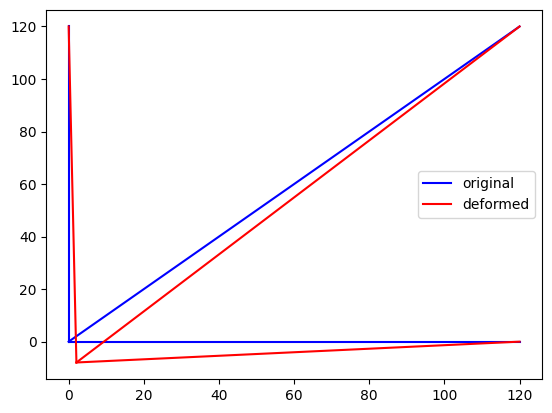

In [9]:
factor = 500
results['deformed_x'] = results['coordinate_x'] + factor*results['displacement_x']
results['deformed_y'] = results['coordinate_y'] + factor*results['displacement_y']
#results.loc[4] = results.loc[0] # adding a new row with values as first row

def original_fig():
    plt.plot(results.loc[0:1,'coordinate_x'],results.loc[0:1,'coordinate_y'],'b-', label = 'original')
    plt.plot(results.loc[[0,2],'coordinate_x'],results.loc[[0,2],'coordinate_y'],'b-')
    plt.plot(results.loc[[0,3],'coordinate_x'],results.loc[[0,3],'coordinate_y'],'b-')
original_fig()

def deformed_fig():
    plt.plot(results.loc[0:1,'deformed_x'],results.loc[0:1,'deformed_y'],'r-', label = 'deformed')
    plt.plot(results.loc[[0,2],'deformed_x'],results.loc[[0,2],'deformed_y'],'r-')
    plt.plot(results.loc[[0,3],'deformed_x'],results.loc[[0,3],'deformed_y'],'r-')
deformed_fig()

plt.legend()
# plt.axis('off')
plt.show()

Determination of stresses in each element

In [10]:
def compute_stress(element):
    N = len(nodes)
    indices = np.arange(N*2)
    indices = indices.reshape(-1,2)
    start = element['start']
    end = element['end']
    indices = np.hstack([indices[start],indices[end]])
    d = U[np.ix_(indices)]
    c, s = element['cos'], element['sin']
    C = (element['material']/element['length'])*np.array([-c, -s, c, s])
    stress = np.dot(C,d)
    return stress
elements['stress'] = elements.apply(compute_stress,axis=1)
elements

,start,end,area,material,length,stiffness,k,cos,sin,stress
0,0,1,2,30000000.0,120.000000,500000.000000,"[[0.0, 0.0, -0.0, -0.0], [0.0, 1.0, -0.0, -1.0...",0.000000,1.000000,3964.466094
1,0,2,2,30000000.0,169.705627,353553.390593,"[[0.4999999999999999, 0.4999999999999999, -0.4...",0.707107,0.707107,1464.466094
2,0,3,2,30000000.0,120.000000,500000.000000,"[[1.0, 0.0, -1.0, -0.0], [0.0, 0.0, -0.0, -0.0...",1.000000,0.000000,-1035.533906
